In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
seed = 99

Using cpu device


In [4]:
## Define custom dataset
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, height, width,status,transforms=None):
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transforms = transforms
        self.status = status

    def __getitem__(self, index):
        single_image_label = self.labels[index]        
        img_as_np = np.asarray(self.data.iloc[index][self.status:]).reshape(28,28).astype('uint8')	
        img_as_img = Image.fromarray(img_as_np)
        #transform image to tensor
        img_as_img = img_as_img.convert('L')    
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)       
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)

In [5]:
## Create custom dataset
transformations = transforms.Compose([transforms.ToTensor()])
imageData = CustomDatasetFromCSV('./train.csv',784,784,1, transformations)

In [6]:
trainData,validationData=train_test_split(imageData,train_size=0.95,random_state=seed)
train_loader = DataLoader(trainData, batch_size = 20)
validation_loader = DataLoader(validationData,batch_size=20)

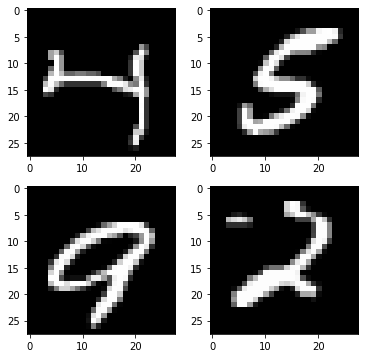

In [7]:
vis_data_normal=next(iter(train_loader))
fig, ax = plt.subplots(2, 2, figsize = (6, 6))
for j in range(0,2):
    for i in range(0,2):
        ax[i, j].imshow(np.squeeze(vis_data_normal[0][i+(j*2)]), cmap='gray')

In [24]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.relu(self.conv1_bn(x))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv2_bn(x))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),0.0005)
total_step = len(train_loader)
epoch = 20
model.train()
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(validation_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.297296  [    0/37800]
loss: 0.320106  [ 2000/37800]
loss: 0.318940  [ 4000/37800]
loss: 0.205226  [ 6000/37800]
loss: 0.112888  [ 8000/37800]
loss: 0.122423  [10000/37800]
loss: 0.055831  [12000/37800]
loss: 0.008835  [14000/37800]
loss: 0.017557  [16000/37800]
loss: 0.068988  [18000/37800]
loss: 0.002631  [20000/37800]
loss: 0.015896  [22000/37800]
loss: 0.001510  [24000/37800]
loss: 0.000426  [26000/37800]
loss: 0.147731  [28000/37800]
loss: 0.002011  [30000/37800]
loss: 0.005051  [32000/37800]
loss: 0.002247  [34000/37800]
loss: 0.015378  [36000/37800]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.038890 

Epoch 2
-------------------------------
loss: 0.006609  [    0/37800]
loss: 0.035932  [ 2000/37800]
loss: 0.090229  [ 4000/37800]
loss: 0.034019  [ 6000/37800]
loss: 0.003008  [ 8000/37800]
loss: 0.164442  [10000/37800]
loss: 0.004148  [12000/37800]
loss: 0.002712  [14000/37800]
loss: 0.004605  [16000/37800]
loss: 0.028854  [18000/37800

In [27]:
torch.save(model.state_dict(),'./model.pth')

In [28]:
class DigitDataset(Dataset):
    def __init__(self,X):
        self.image = X/255 
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = self.image[idx]
        return torch.FloatTensor(image)
test_dir = './test.csv'
test_data = pd.read_csv(test_dir)

test_data = np.array(test_data)
test_data = test_data.reshape(-1,1,28,28)
tensor_test = DigitDataset(test_data)
test_loader = DataLoader(tensor_test, batch_size = 1)
nn_model = NeuralNetwork()
nn_model.load_state_dict(torch.load('./model.pth'))

def test():
    nn_model.eval()
    submission = pd.DataFrame(columns=['ImageId','Label'])
    id = 1 #It has to start in 1 accordingly to the rules
    id_list = []
    guess = []
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            outputs = nn_model(data)
            _, predicted = torch.max(outputs.data, 1)
            id_list.append(id)
            guess.append(predicted.item())
            id+=1
            
    submission['ImageId'] = id_list
    submission['Label'] = guess
    
    submission.to_csv("submission.csv",index=False)
            


In [29]:
test()

100%|██████████| 28000/28000 [00:11<00:00, 2459.73it/s]
